In [1]:
import matplotlib.pyplot as plt
import stlearn as st
import scanpy as sc
import numpy as np

/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
import os
os.getcwd()

'/data/User/revolvefire/projects/Xenium'

In [3]:
adata = st.ReadXenium(feature_cell_matrix_file="/mnt/gmi-l1/_90.User_Data/revolvefire/fastq/Xenium/E18_reseg/outs/cell_feature_matrix.h5",
                     cell_summary_file="/mnt/gmi-l1/_90.User_Data/revolvefire/fastq/Xenium/E18_reseg/outs/cells.csv.gz",
                     library_id="e18_reseg",
                     #image_path="/mnt/gmi-l1/_90.User_Data/revolvefire/fastq/Xenium/PD2_reseg/outs/morphology_focus.ome.tif",
                     scale=1,
                     spot_diameter_fullres=15 # Recommend
                     )

In [4]:
adata

AnnData object with n_obs × n_vars = 18579 × 297
    obs: 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata,min_counts=10)

In [6]:
# Store the raw data for using PSTS
adata.raw = adata

In [7]:
adata.raw = adata
# Normalization data
sc.pp.normalize_total(adata)

In [8]:
# Squareroot normalize transcript counts. We need to deal with sparse matrix of .X
#from scipy.sparse import csr_array
#adata.X = np.sqrt(adata.X.toarray()) + np.sqrt(adata.X.toarray() + 1)
# If the matrix is small, we don't need to convert to numpy array. I believe, Xenium data is always large
# adata.X = csr_array(np.sqrt(adata.X) + np.sqrt(adata.X + 1))

# If you want to use log transformation, please use:
st.pp.log1p(adata)

Log transformation step is finished in adata.X


In [9]:
adata

AnnData object with n_obs × n_vars = 17697 × 296
    obs: 'imagecol', 'imagerow', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [10]:
# Run PCA
st.em.run_pca(adata,n_comps=50,random_state=0)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [11]:
# Compute neighborhood graph of cells using the PCA representation
st.pp.neighbors(adata,n_neighbors=25,use_rep='X_pca',random_state=0)

2025-03-05 14:55:43.691611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 14:55:43.782538: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


In [12]:
sc.tl.leiden(adata, resolution=1.0)

In [13]:
adata

AnnData object with n_obs × n_vars = 17697 × 296
    obs: 'imagecol', 'imagerow', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
sc.tl.umap(adata)

/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


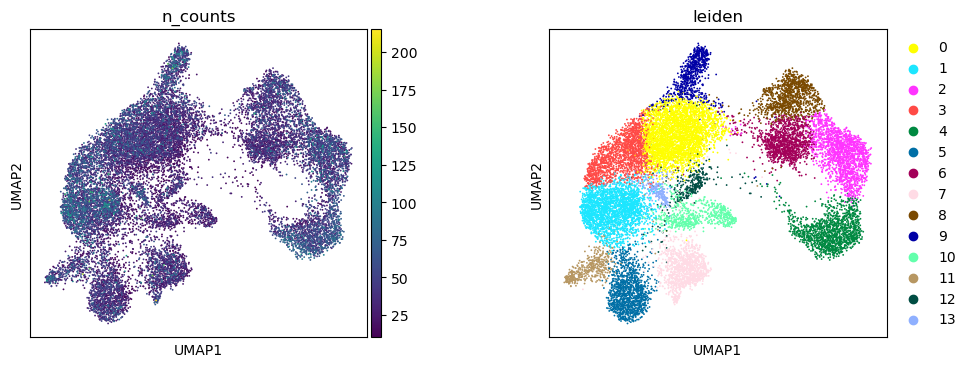

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["n_counts", "leiden"], palette=sc.pl.palettes.default_102, wspace=0.4)

In [16]:
# scale and store results in layer
adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X

In [17]:
print(adata.obs["leiden"].unique())

['5', '7', '1', '10', '0', ..., '12', '9', '8', '4', '2']
Length: 14
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']


In [18]:
cluster_mapping = {
    "0": "Papillary FIB",
    "1": "Ret/Int FIB",
    "2": "BK",
    "3": "Ret/Hypo FIB",
    "4": "SBK",
    "5": "PCM",
    "6": "HFKC",
    "7": "EC",
    "8": "Hair matrix",
    "9": "DC/DP",
    "10": "Immune cell",
    "11": "Pericyte",
    "12": "Schwann cell",
    "13": "Adipocyte"
    
    # Add more mappings as needed
}


In [19]:
adata.obs["leiden"] = adata.obs["leiden"].map(cluster_mapping)

In [20]:
adata.obs["leiden"]

aaaaljdl-1            PCM
aaadldhm-1            PCM
aaadohfh-1             EC
aaaelhek-1            PCM
aaaemjdc-1            PCM
                 ...     
oiebgklc-1    Ret/Int FIB
oiedlhkl-1             EC
oiefgedg-1    Ret/Int FIB
oiefnmcb-1    Ret/Int FIB
oieogghl-1    Ret/Int FIB
Name: leiden, Length: 17697, dtype: category
Categories (14, object): ['Papillary FIB', 'Ret/Int FIB', 'BK', 'Ret/Hypo FIB', ..., 'Immune cell', 'Pericyte', 'Schwann cell', 'Adipocyte']

In [21]:
new_order = ['DC/DP', 'Papillary FIB', 'Ret/Int FIB', 'Ret/Hypo FIB', 'Adipocyte', 'PCM', 'BK', 'SBK', 'HFKC', 'Hair matrix', 'EC', 'Pericyte', 'Immune cell', 'Schwann cell'
]

In [22]:
# Convert the column to categorical dtype
adata.obs["leiden"] = adata.obs["leiden"].astype('category')


In [23]:
# Validate the mapping
current_categories = adata.obs["leiden"].cat.categories
print("Current categories:", current_categories)

# Check new order consistency
new_order_set = set(new_order)
current_categories_set = set(current_categories)

print("Missing in new_order:", current_categories_set - new_order_set)
print("Extra in new_order:", new_order_set - current_categories_set)

Current categories: Index(['Papillary FIB', 'Ret/Int FIB', 'BK', 'Ret/Hypo FIB', 'SBK', 'PCM',
       'HFKC', 'EC', 'Hair matrix', 'DC/DP', 'Immune cell', 'Pericyte',
       'Schwann cell', 'Adipocyte'],
      dtype='object')
Missing in new_order: set()
Extra in new_order: set()


In [24]:
adata.obs["leiden"] = adata.obs["leiden"].cat.reorder_categories(new_order, ordered=True)


In [25]:
markers=['Itga8', 'Myocd', 'Mef2c', 'Col11a1', 'Lrrc15', 'Ebf1', 'Corin', 'Alx4', 'Wnt5a','Twist2', 'Pdgfra', 'Dpp4', 'Dlk1', 'Agtr2', 'Ly6a', 'Cxcl12', 'Adipoq','Mfap5', 'Igf2', 'Myl4', 'Krt5', 'Krt1', 'Barx2', 'Foxc1', 'Sox9', 'Msx2', 'Pecam1', 'Gucy1a1', 'Maf', 'Cd68', 'Cd53', 'Ikzf1', 'Sox10']

In [26]:
sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300)

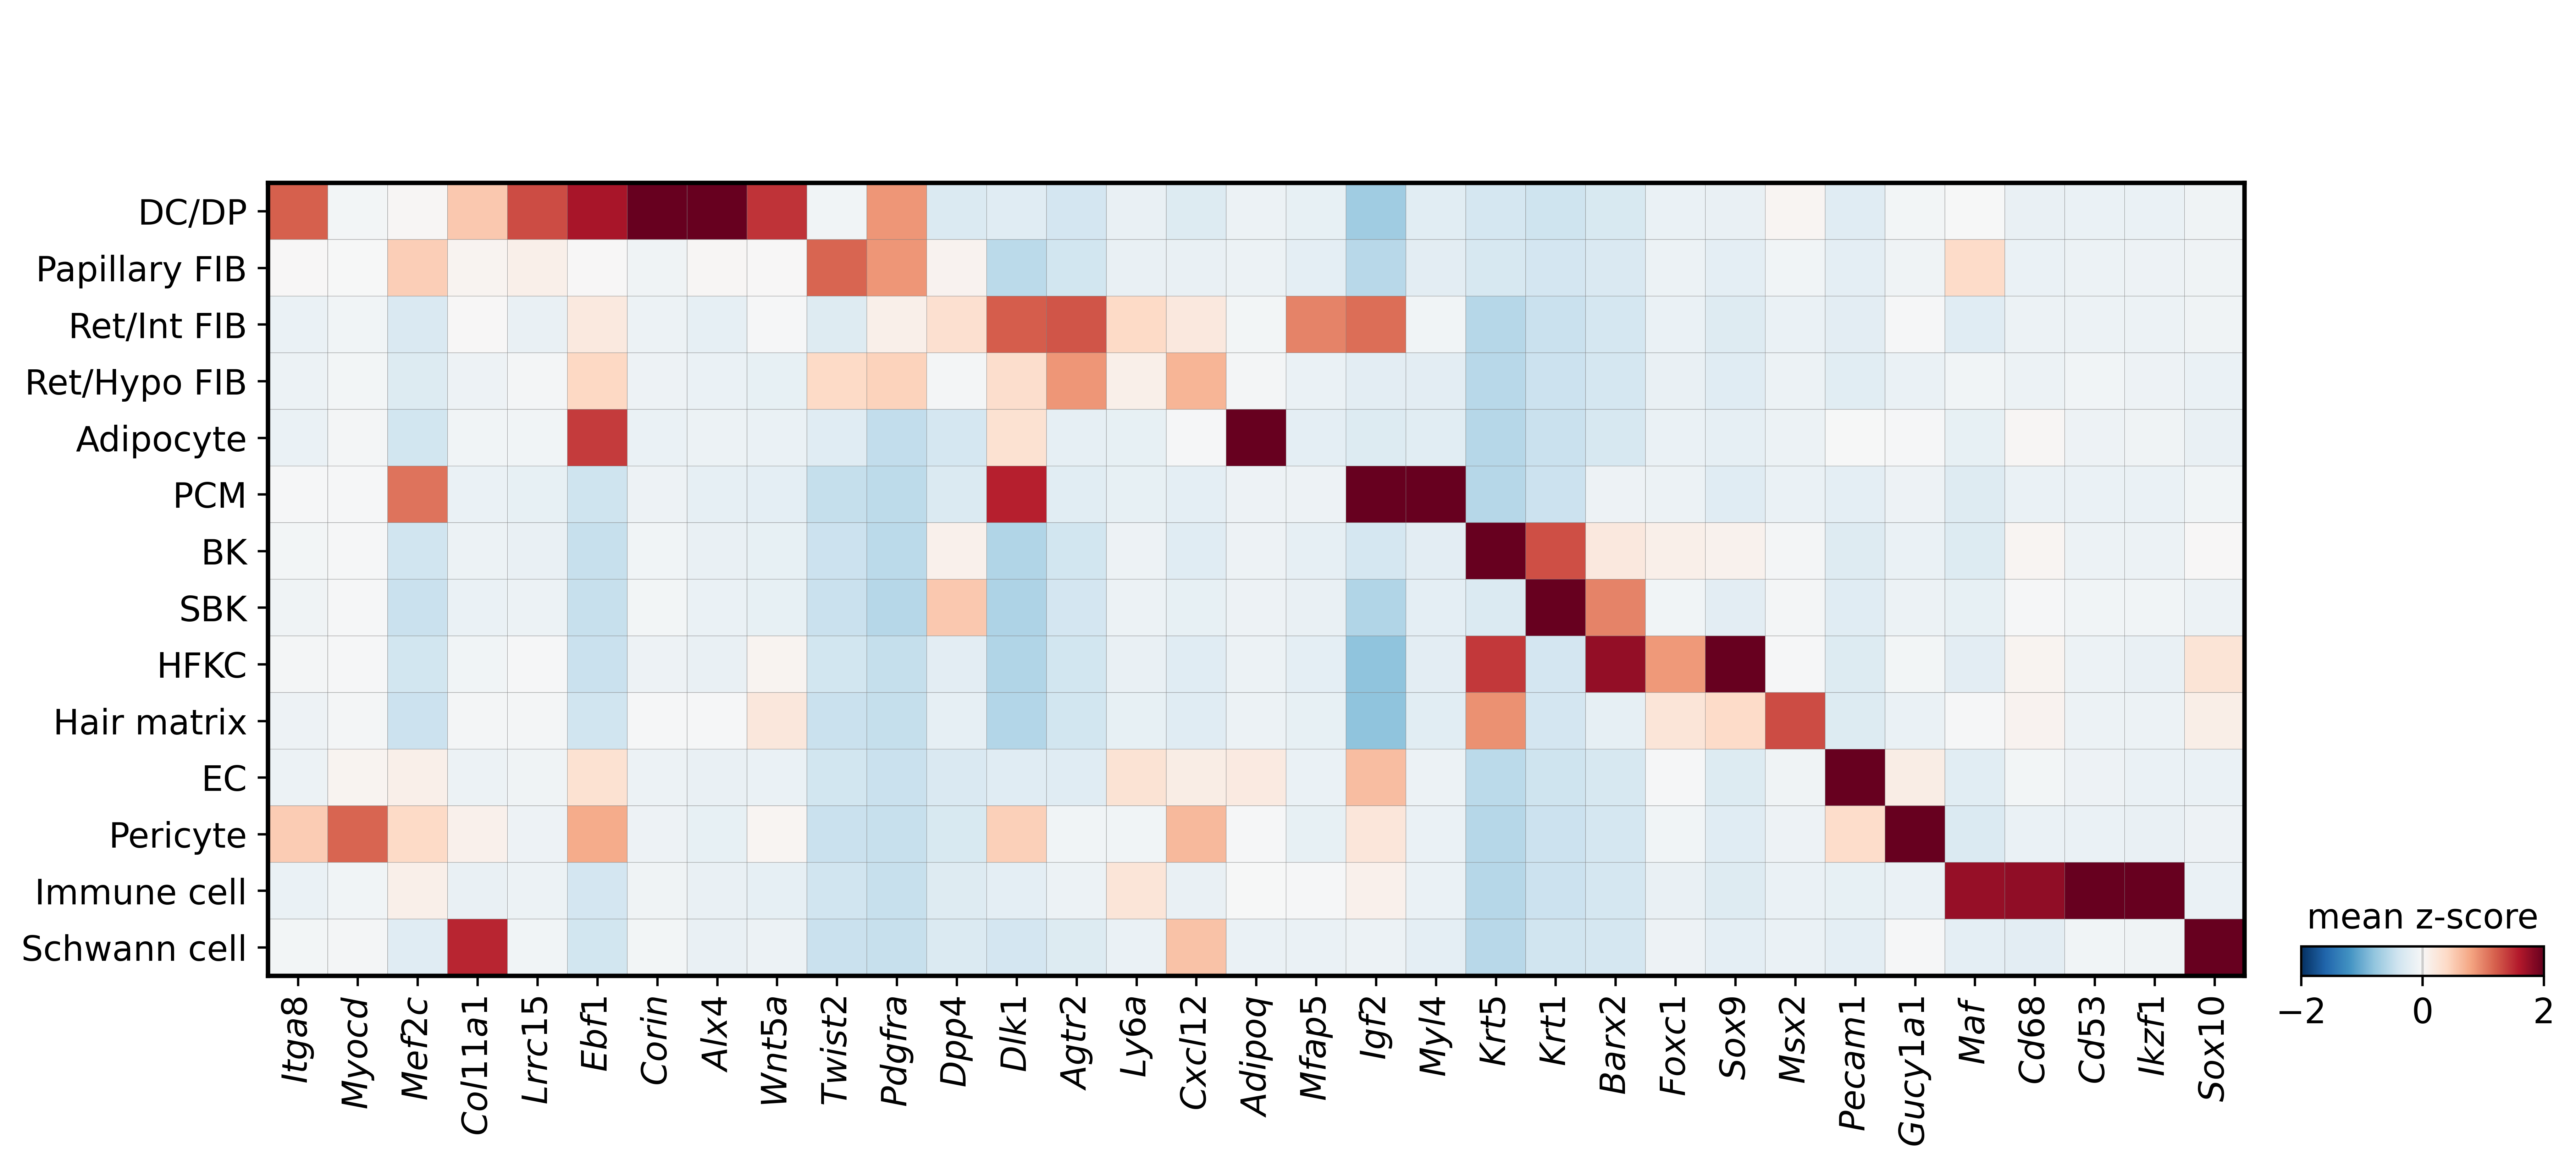

In [27]:
sc.pl.matrixplot(
    adata,
    markers,
    groupby="leiden",
    dendrogram=False,
    cmap="RdBu_r",
    layer="scaled",
    vmin=-2, vmax=2,
    show=False, colorbar_title="mean z-score" 
)
fig = plt.gcf()
ax = fig.axes[0]
tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
italic_labels = [f"$\\mathit{{{label}}}$" for label in tick_labels]

ax.set_xticks(np.arange(len(tick_labels)) + 0.5)
ax.set_xticklabels(italic_labels, )

plt.savefig("250305.E18.matrixplot_custom.svg", bbox_inches="tight")
plt.show()

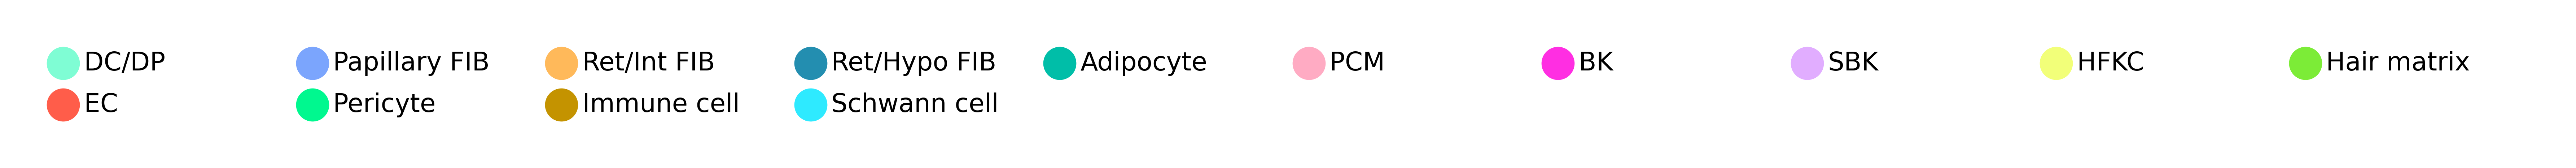

In [38]:
import matplotlib.pyplot as plt

# Define the data for the legend
labels = ['DC/DP', 'Papillary FIB', 'Ret/Int FIB', 'Ret/Hypo FIB', 'Adipocyte', 'PCM', 'BK', 'SBK', 'HFKC', 'Hair matrix', 'EC', 'Pericyte', 'Immune cell', 'Schwann cell'
]

colors = [
    '#7FFDD4', '#7BA5FD', '#FFB95A', '#238EB0', '#00BEA8', '#FFABC3',
    '#FF2EE2', '#E1ADFF', '#F2FF79', '#7CEC37', '#FF5D4A', '#00F88F',
    '#C49300', '#2EEAFF'
]

# Number of rows and columns for the legend grid
n_cols = 10 # Number of columns
n_rows = -(-len(labels) // n_cols)  # Calculate rows based on the number of items

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 2))
ax.axis('off')  # Turn off the axis

# Adjust spacing between labels
horizontal_spacing = 6  # Horizontal spacing
vertical_spacing = 1.0    # Vertical spacing

# Add legend entries
for i, (label, color) in enumerate(zip(labels, colors)):
    row = i // n_cols  # Calculate the row index
    col = i % n_cols  # Calculate the column index
    ax.scatter(col * horizontal_spacing, -row * vertical_spacing, color=color, s=100)  # Add the color marker
    ax.text(col * horizontal_spacing + 0.5, -row * vertical_spacing, label, va='center', fontsize=8.5)  # Add the label

# Adjust the limits
ax.set_xlim(-1, n_cols * horizontal_spacing)
ax.set_ylim(-n_rows * vertical_spacing, 1)
ax.set_aspect('equal')

# Save the plot as a high-resolution image
plt.savefig("25228.e18.legend_high_res.svg", dpi=600, bbox_inches='tight')  # Save with 300 dpi and tight bounding box
plt.show()

/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


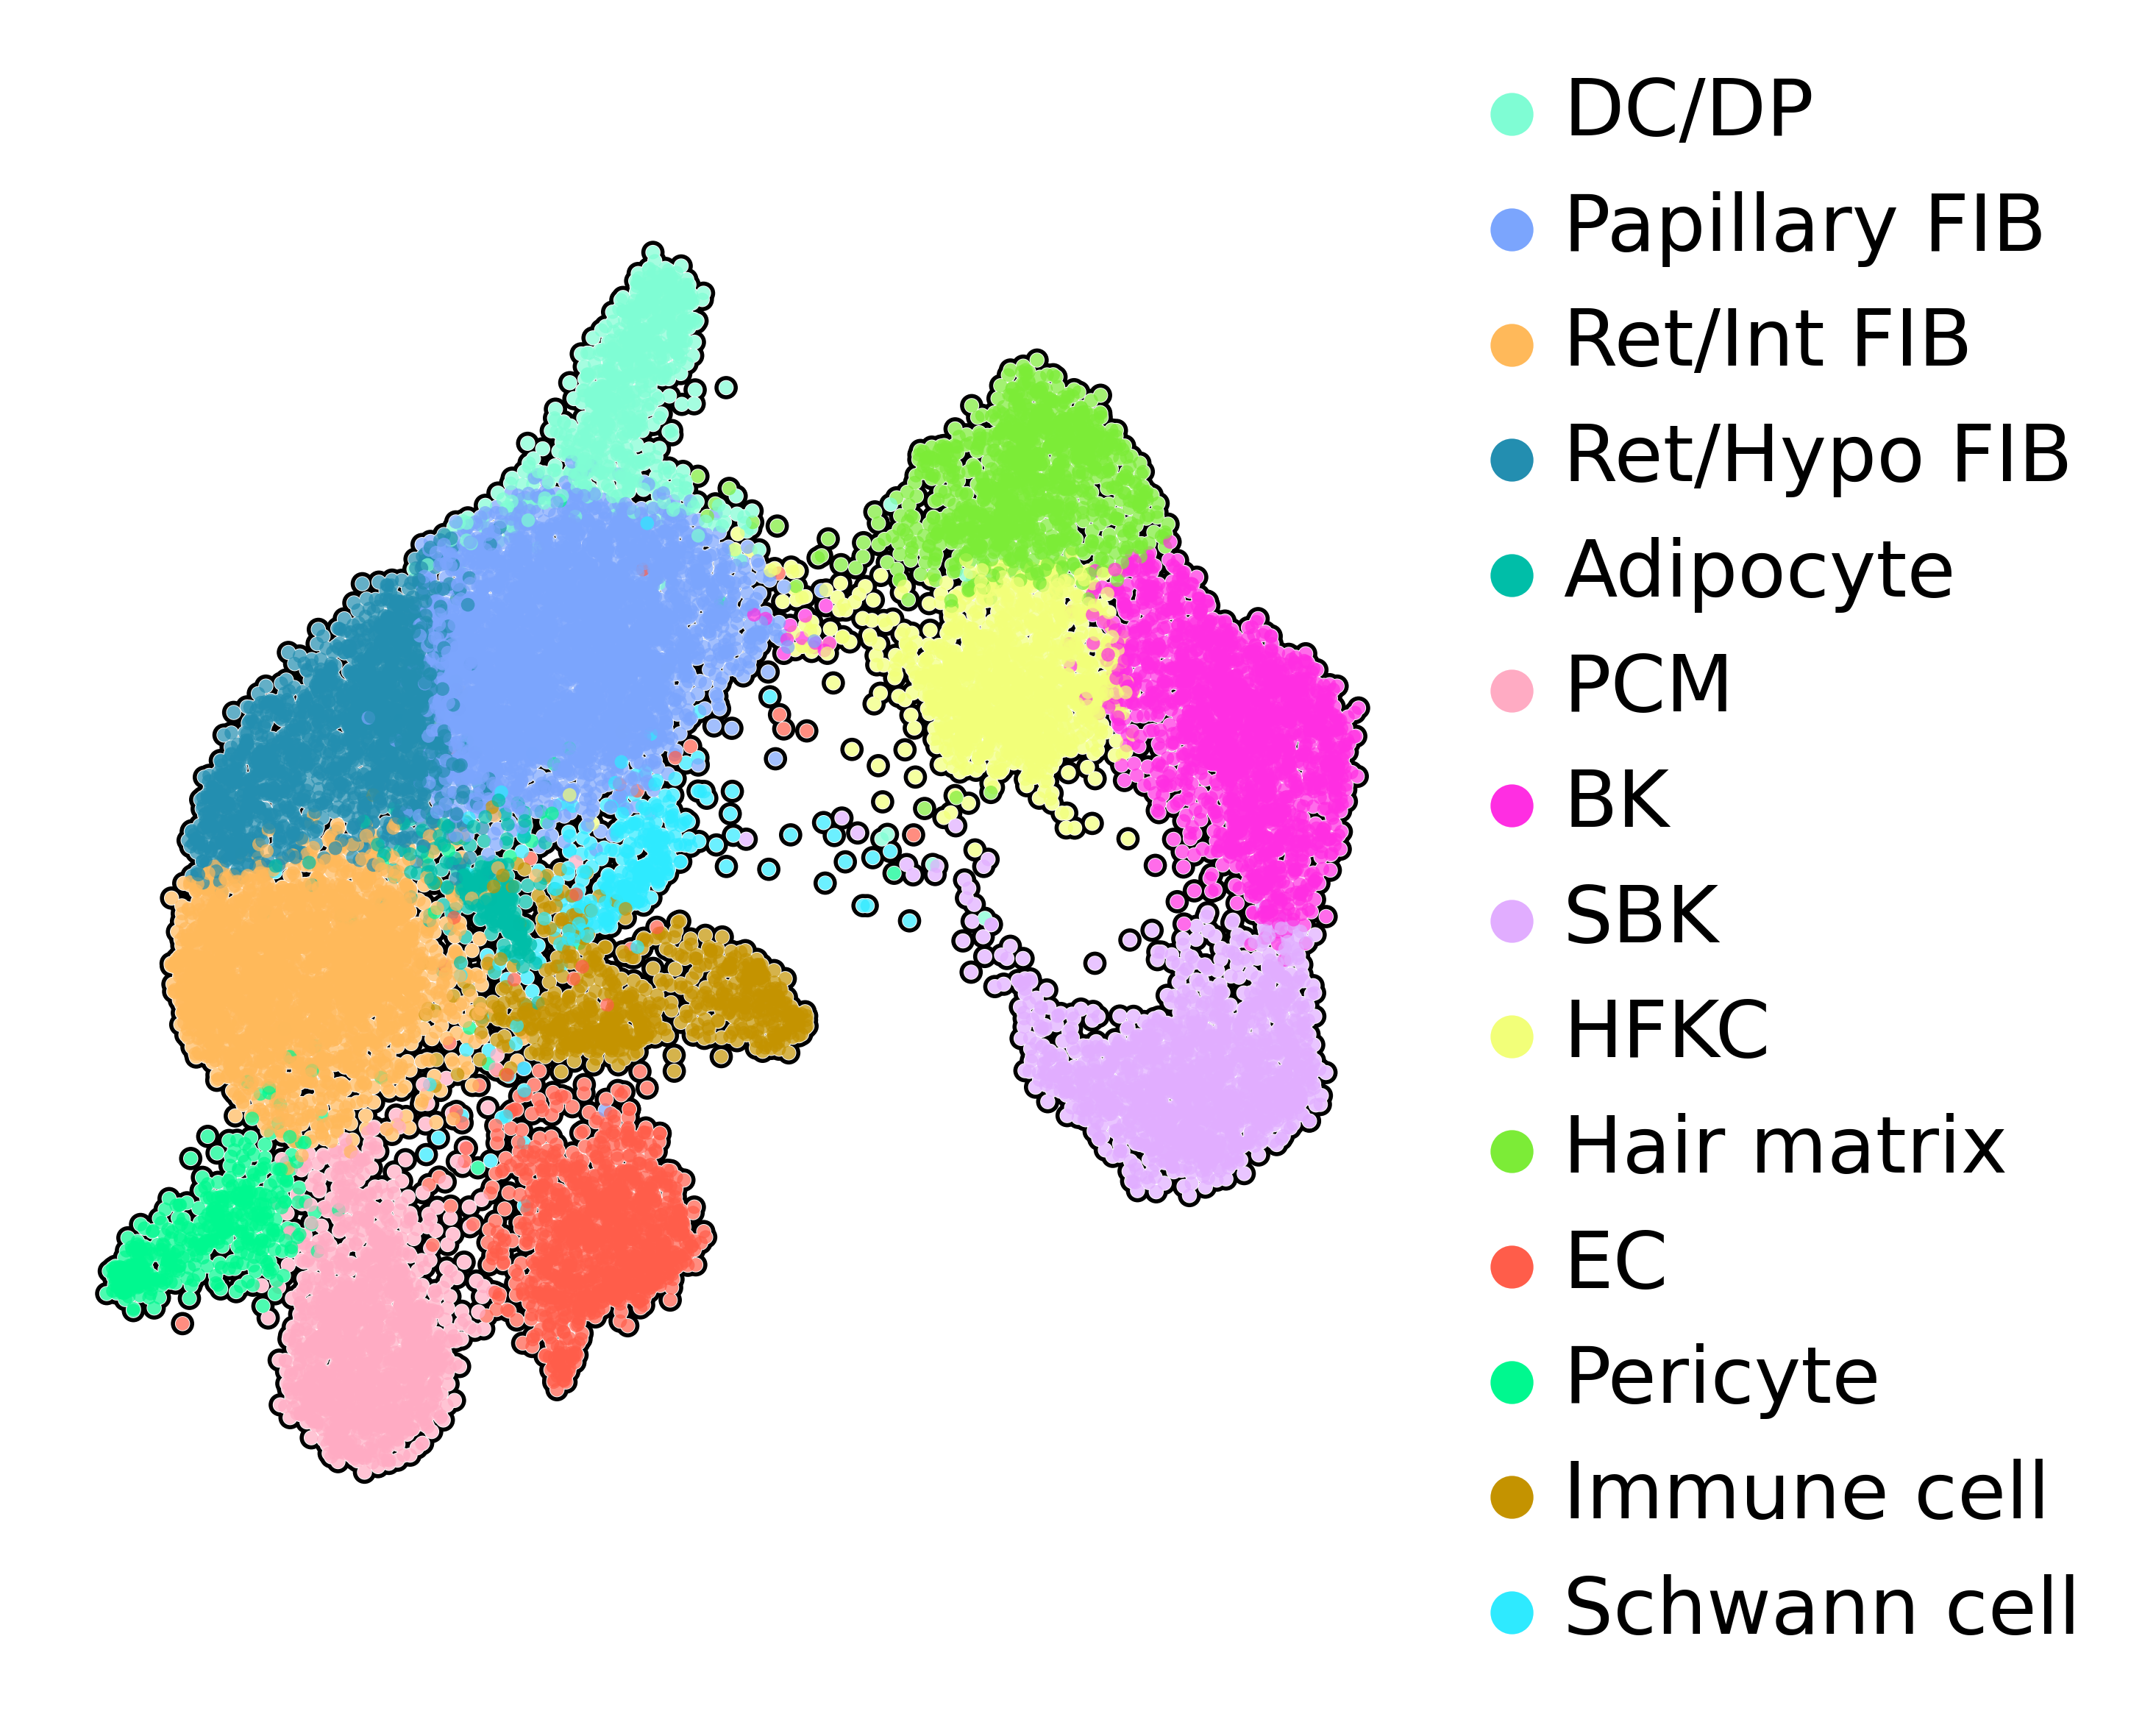

In [28]:
new_colors = [
  '#7FFDD4', '#7BA5FD', '#FFB95A', '#238EB0', '#00BEA8', '#FFABC3',
    '#FF2EE2', '#E1ADFF', '#F2FF79', '#7CEC37', '#FF5D4A', '#00F88F',
    '#C49300', '#2EEAFF'
]

# Update the color palette for leiden categories
sc.pl.umap(
    adata,
    color="leiden",  # Ensure "leiden" matches your labels
    palette=new_colors,  # Apply the reordered color palette
    size=20, title="", # Adjust marker size if necessary
    wspace=0.4 , add_outline=True, frameon=False, save="25305.e18.spatial.UMAP.svg"
)

/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


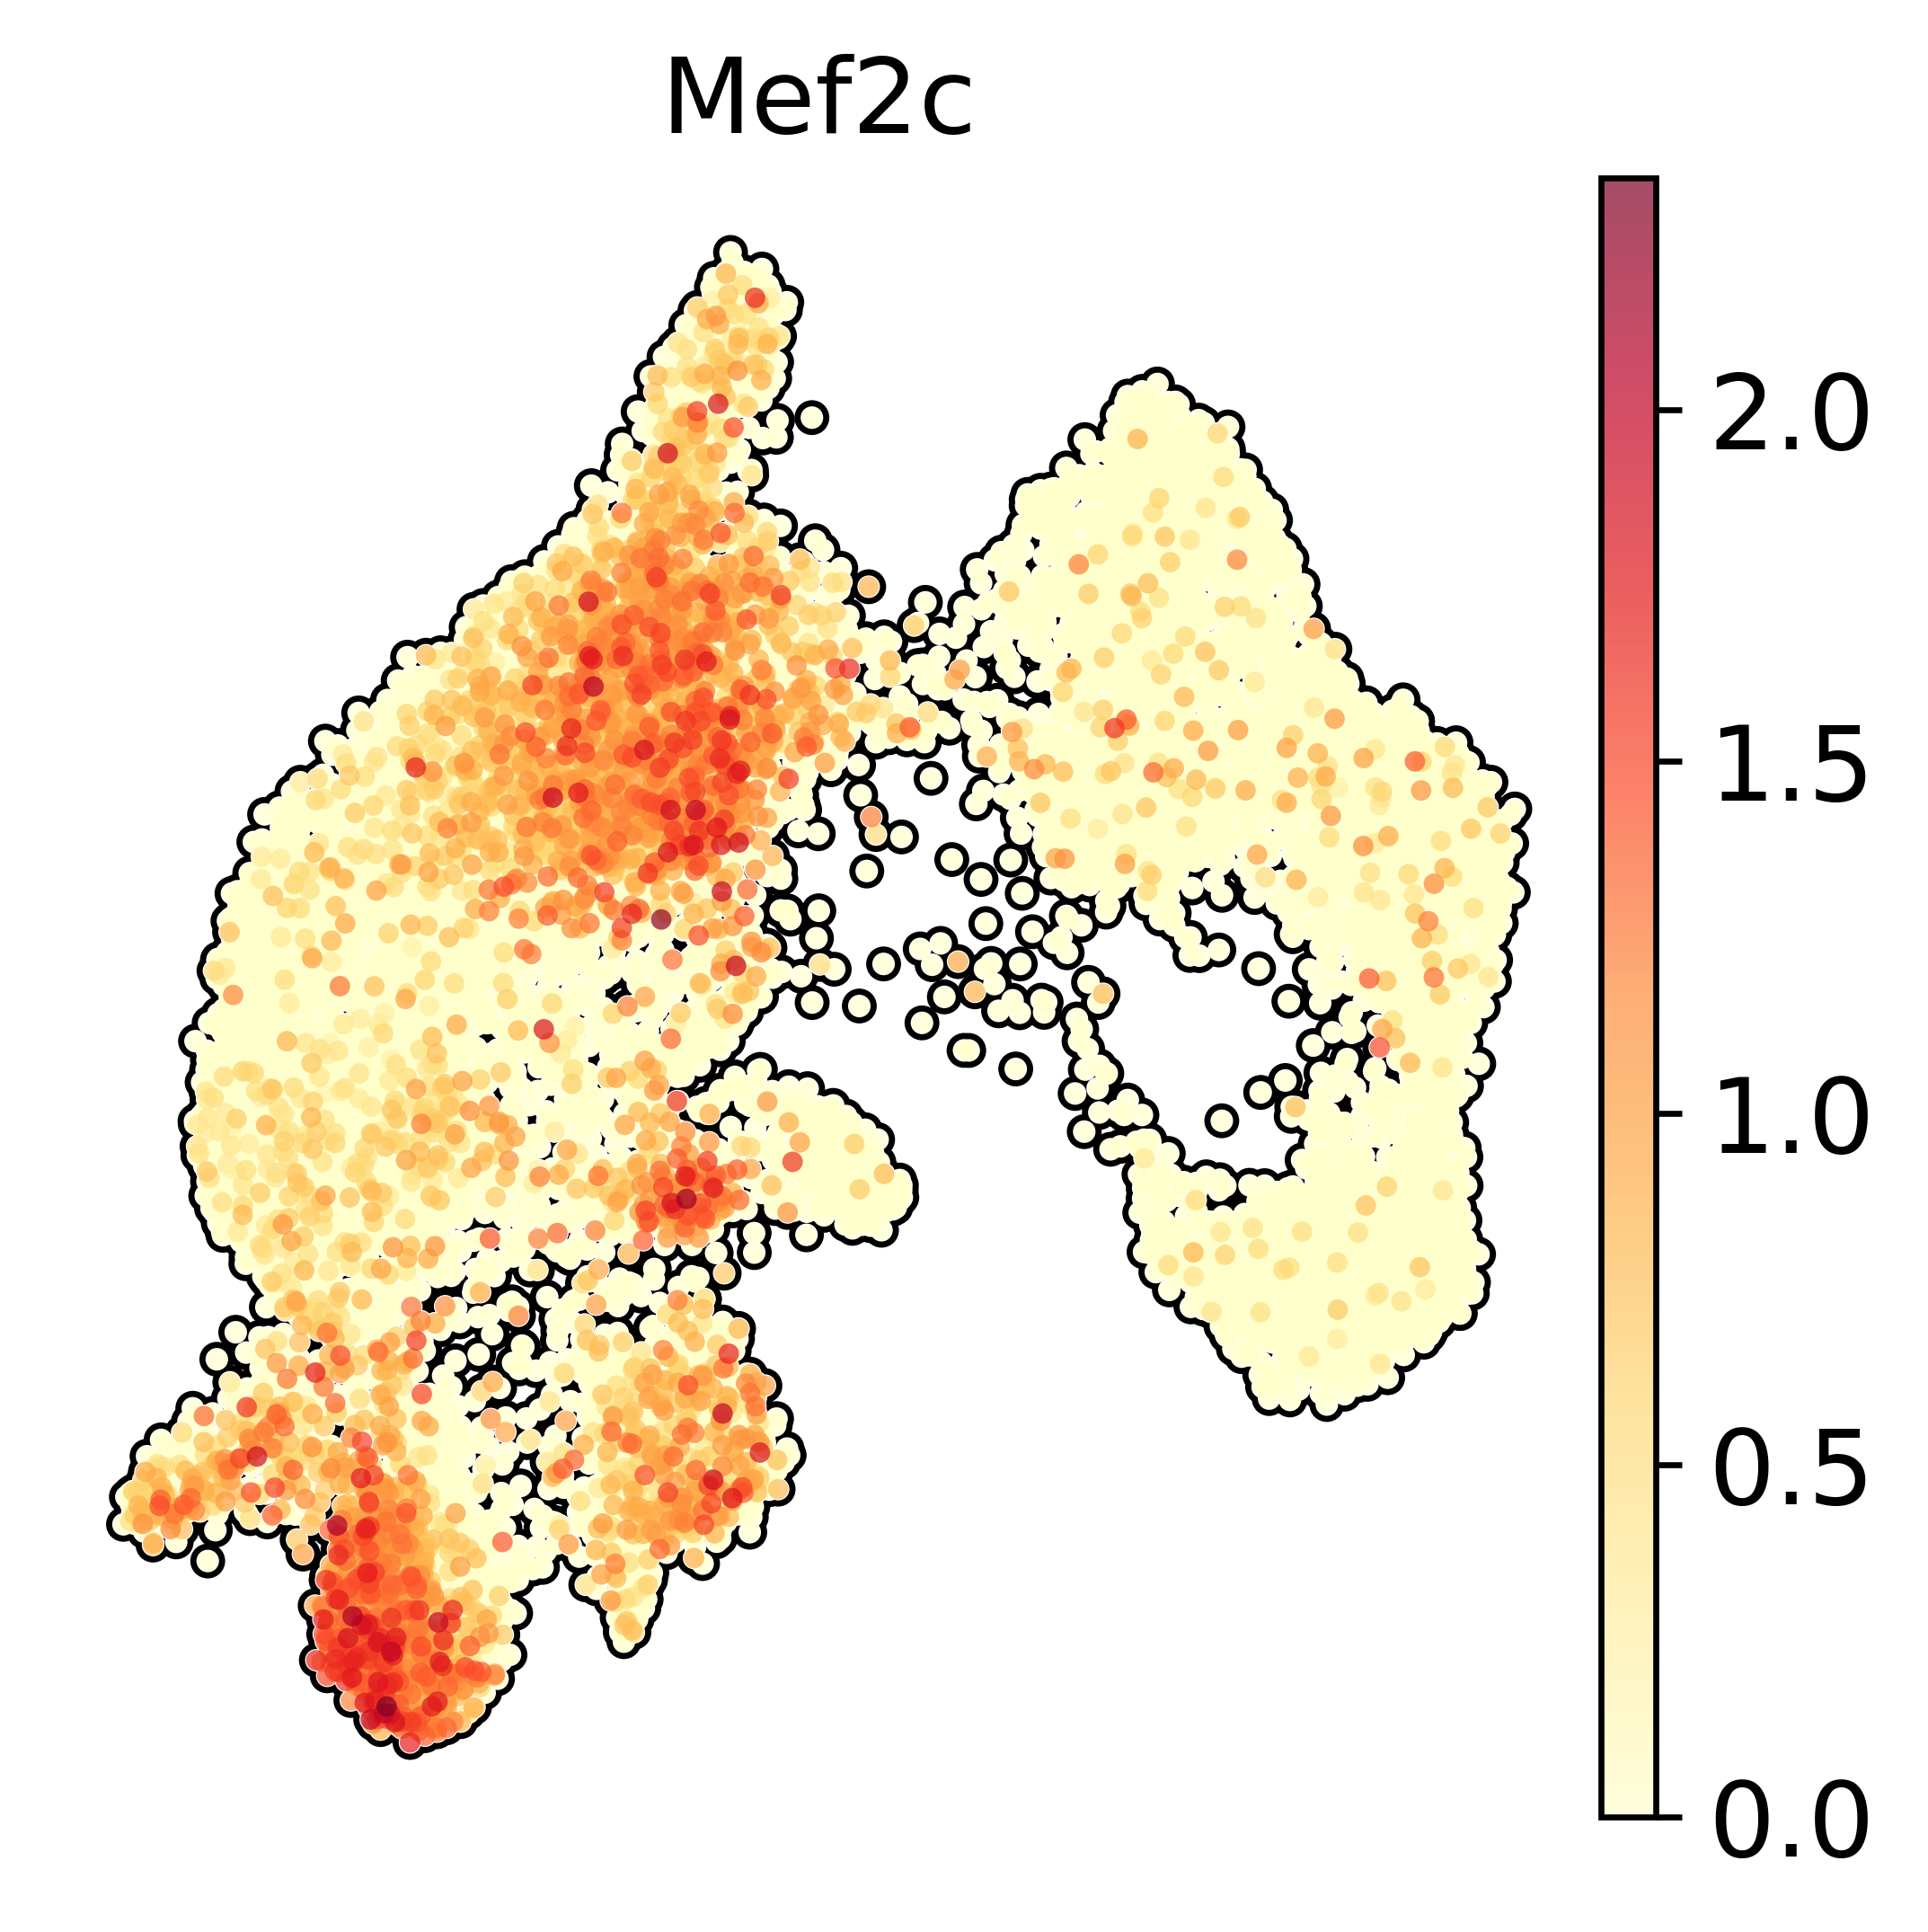

In [29]:
# Update the color palette for leiden categories
sc.pl.umap(
    adata,
    color="Mef2c", cmap="YlOrRd", # Ensure "leiden" matches your labels
    palette=new_colors,  # Apply the reordered color palette
    size=30,  # Adjust marker size if necessary
    wspace=0.4 , add_outline=True, frameon=False, save="250305.e18.mef2c.spatial.UMAP.svg"
)

/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


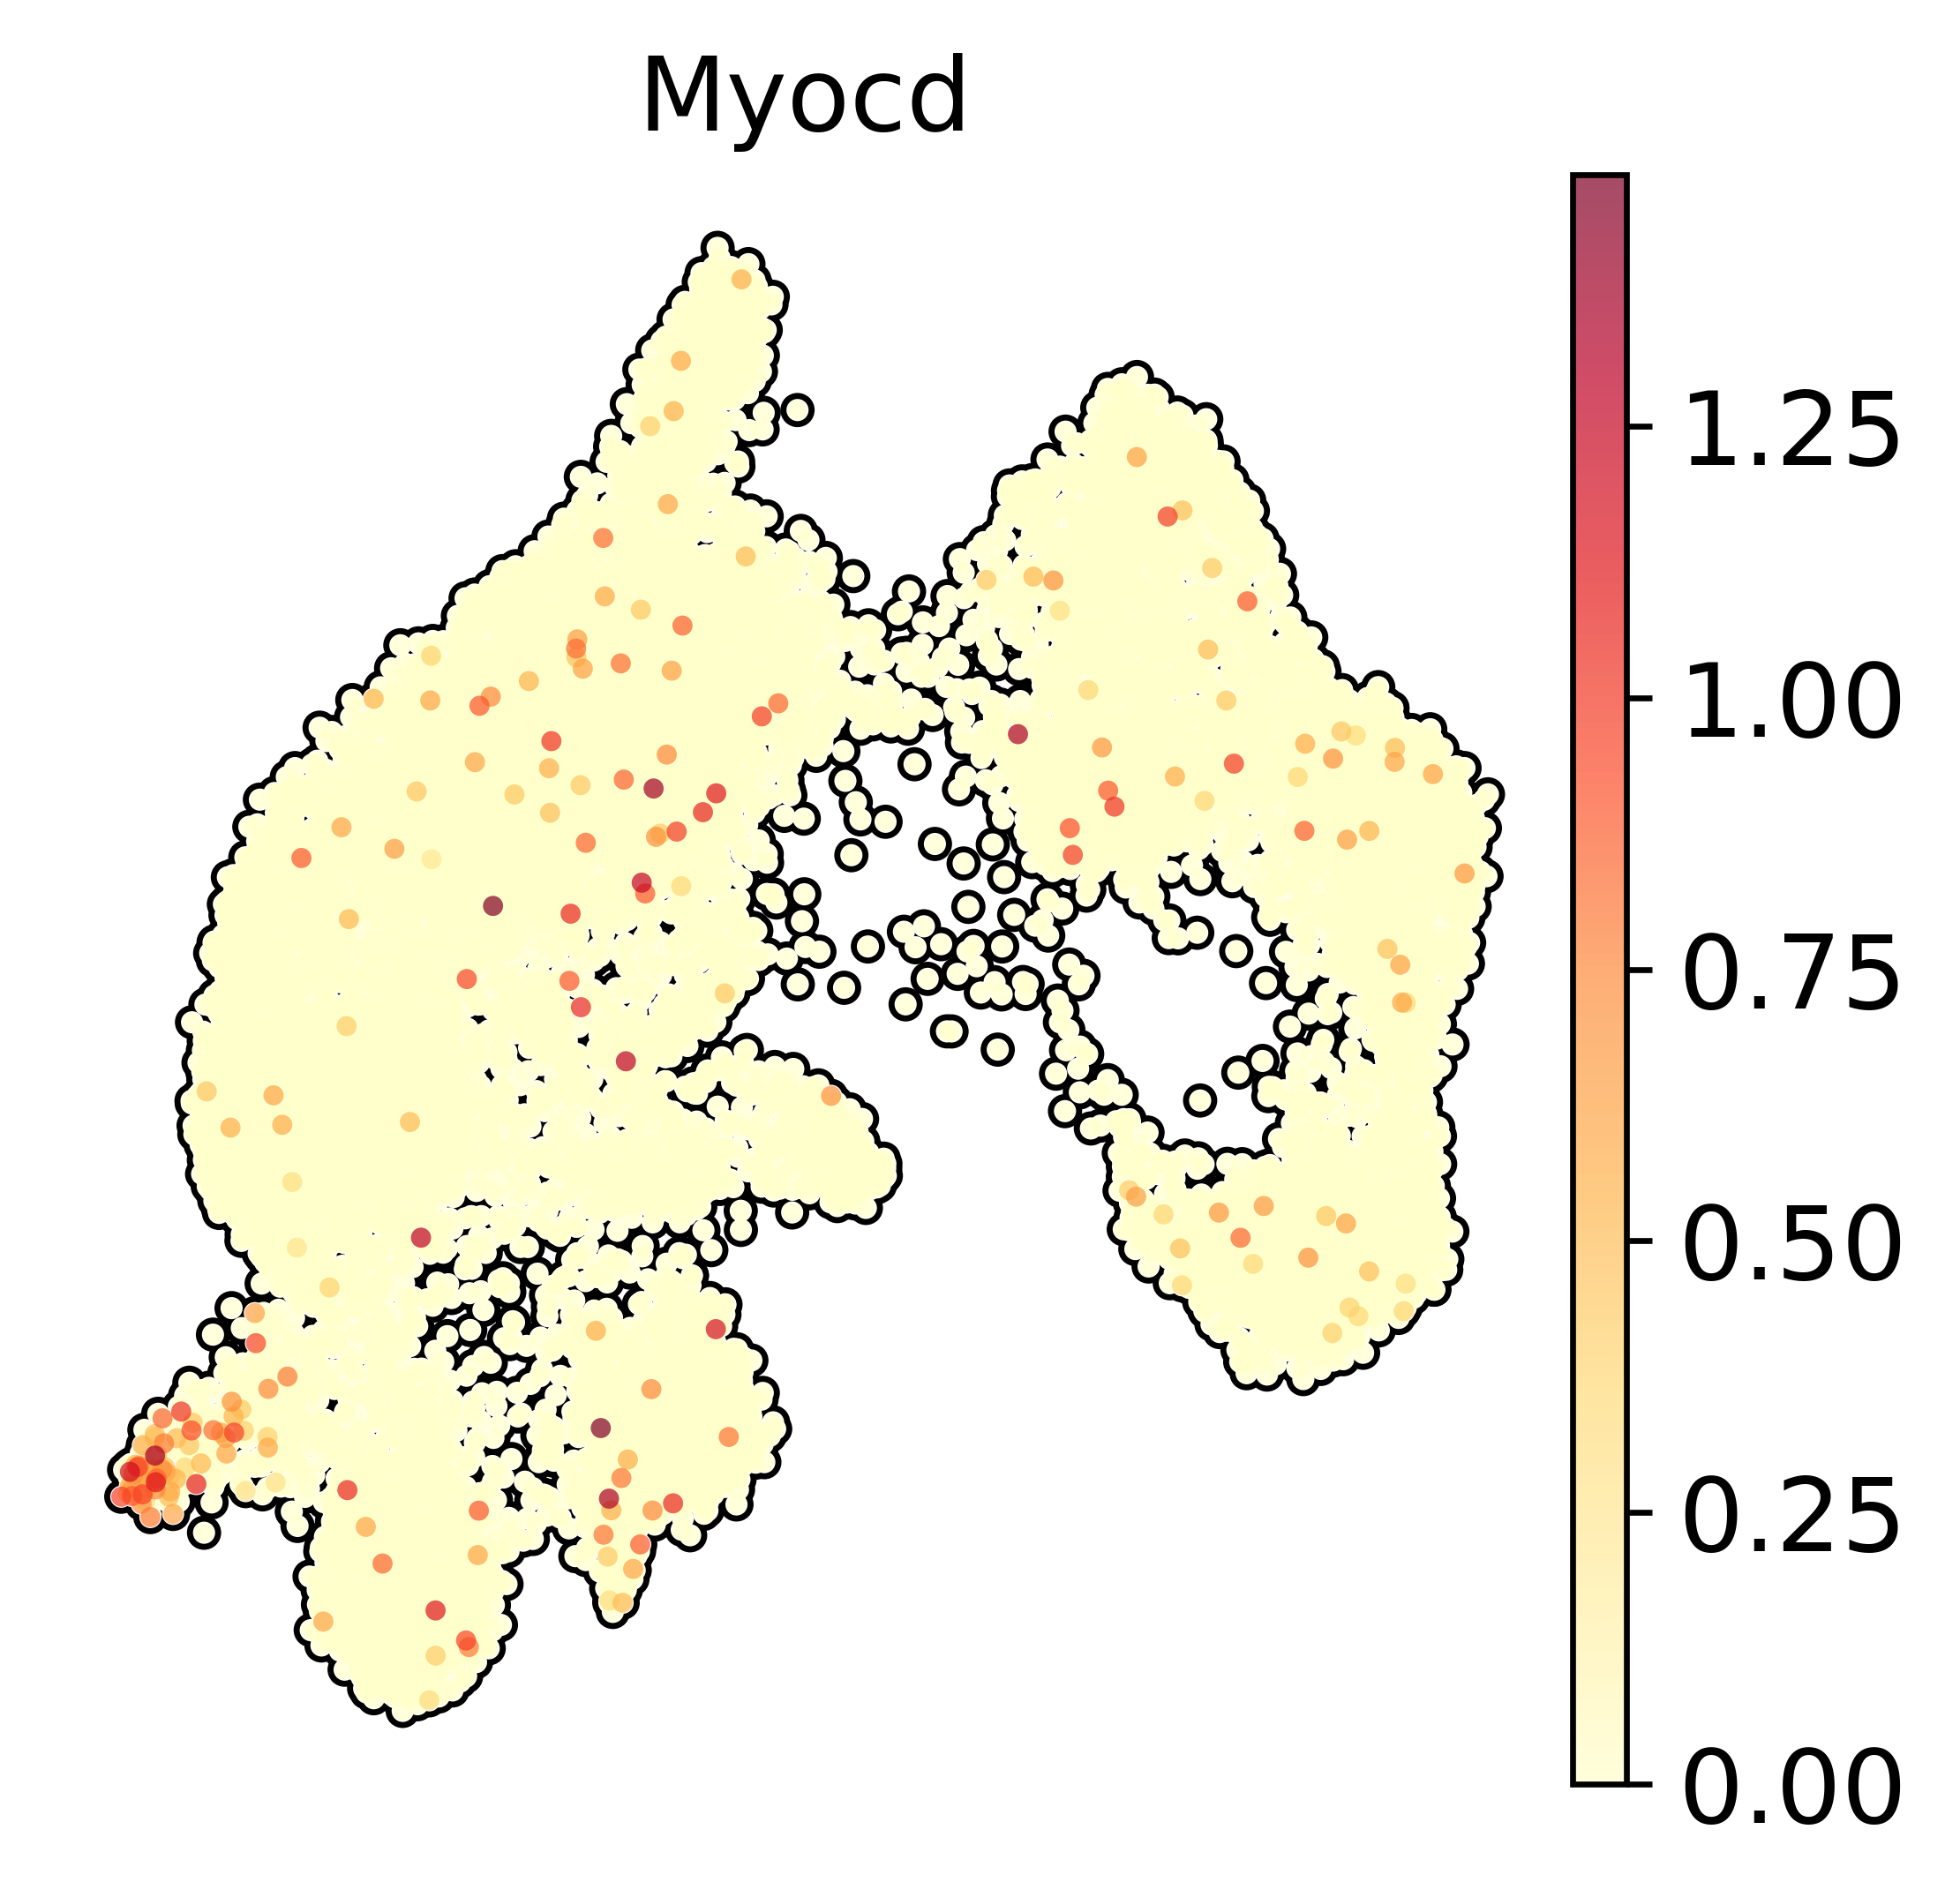

In [30]:
# Update the color palette for leiden categories
sc.pl.umap(
    adata,
    color="Myocd",  cmap="YlOrRd",# Ensure "leiden" matches your labels
    palette=new_colors,  # Apply the reordered color palette
    size=30,  # Adjust marker size if necessary
    wspace=0.4 , add_outline=True, frameon=False, save="250305.e18.myocd.spatial.UMAP.svg"
)

/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/mnt/gmi-l1/_90.User_Data/revolvefire/miniforge3/envs/stlearn_250218/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


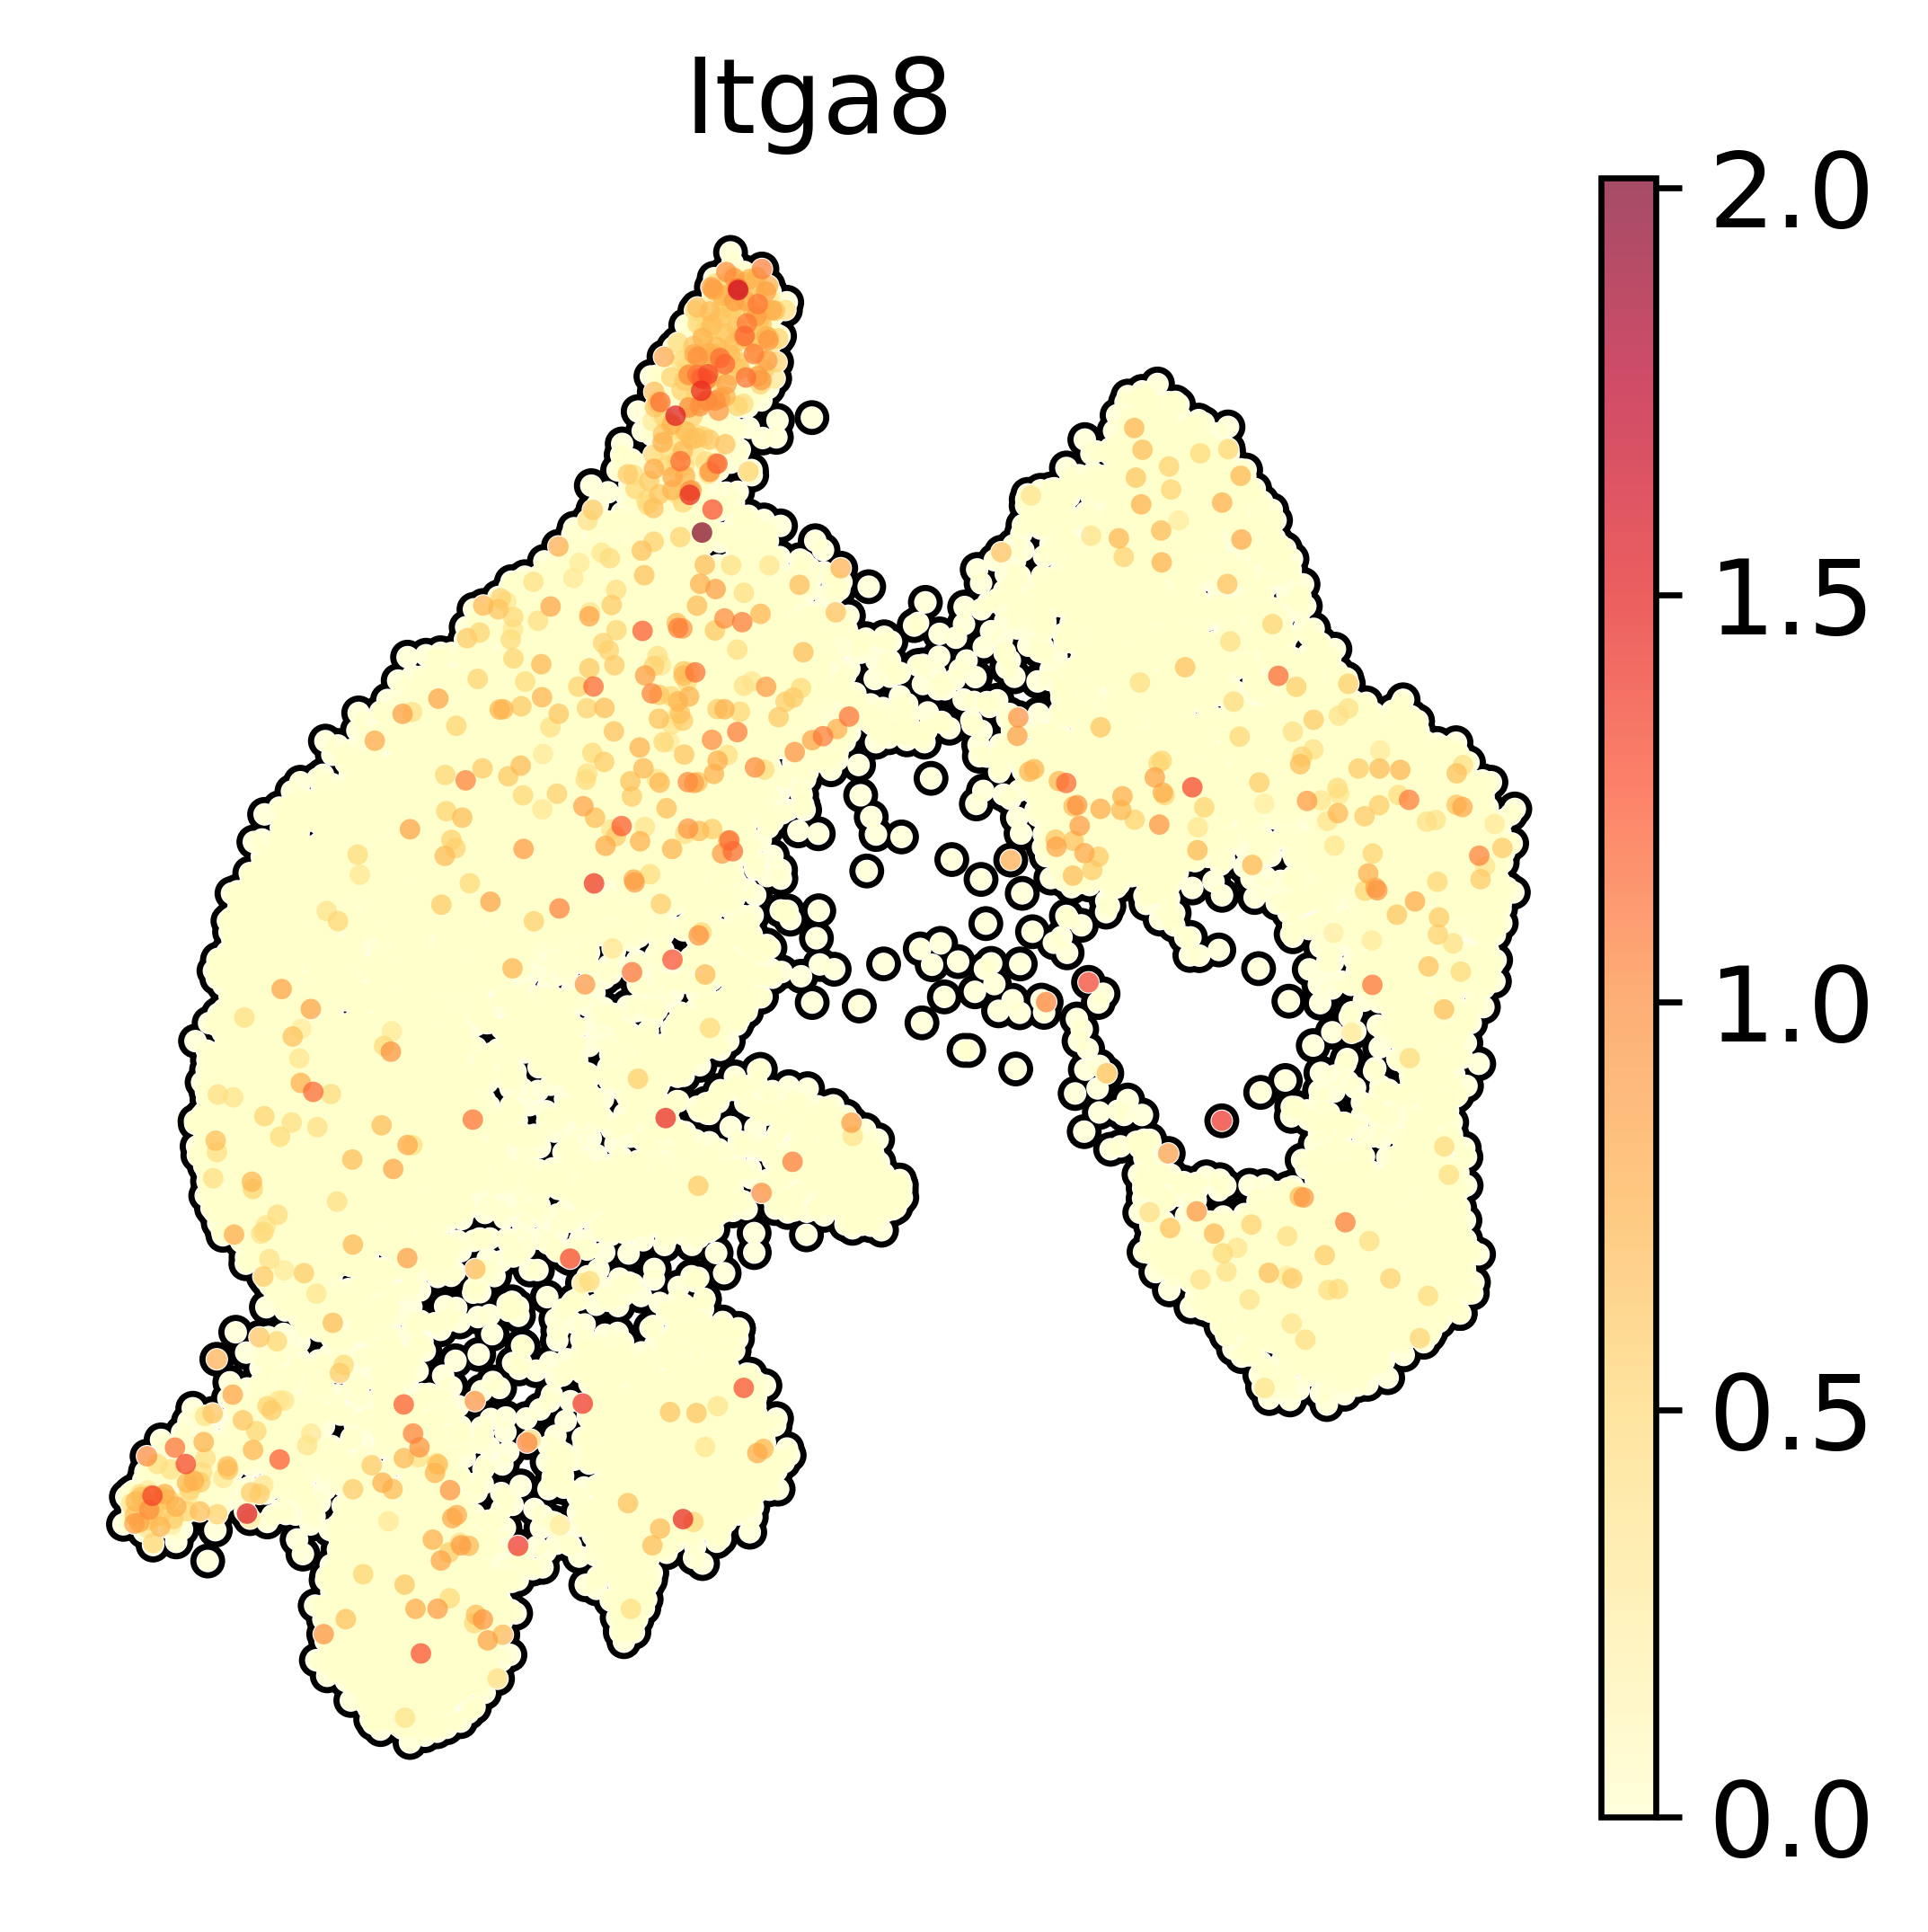

In [31]:
# Update the color palette for leiden categories
sc.pl.umap(
    adata,
    color="Itga8",  cmap="YlOrRd",# Ensure "leiden" matches your labels
    palette=new_colors,  # Apply the reordered color palette
    size=30,  # Adjust marker size if necessary
    wspace=0.4 , add_outline=True, frameon=False, save="250305.e18.itga8.spatial.UMAP.svg"
)

In [ ]:
#for xenium explorer

In [32]:
leiden_df = adata.obs["leiden"].reset_index()

# Rename the columns to 'cell_id' and 'leiden'
leiden_df.columns = ['cell_id', 'group']

# Save the DataFrame to a CSV file
leiden_df.to_csv('labeld_e18_250305.csv', index=False)

In [33]:
adata.write("250305.e18.spatial.final.h5ad")